In [2]:
import numpy as np 
import pandas as pd 
import os 
# We have downloaded dataset from - https://www.kaggle.com/dgawlik/nyse
print(os.listdir("Dataset/"))

['fundamentals.csv', 'goog_current_data.csv', 'prices-split-adjusted.csv', 'prices.csv', 'securities.csv']


In [4]:
# Import essential libraries for ARIMA Model and plotting

import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA


In [6]:
# importing data

df = pd.read_csv("Dataset/prices-split-adjusted.csv",index_col=0)

df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [8]:
df.symbol.unique()

array(['WLTW', 'A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACN', 'ADBE',
       'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AET',
       'AFL', 'AGN', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL',
       'ALXN', 'AMAT', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN',
       'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB',
       'AVGO', 'AVY', 'AWK', 'AXP', 'AYI', 'AZO', 'BA', 'BAC', 'BAX',
       'BBBY', 'BBT', 'BBY', 'BCR', 'BDX', 'BEN', 'BHI', 'BIIB', 'BK',
       'BLK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CA', 'CAG', 'CAH',
       'CAT', 'CB', 'CBG', 'CBS', 'CCI', 'CCL', 'CELG', 'CERN', 'CF',
       'CHD', 'CHK', 'CHRW', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA',
       'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COH',
       'COL', 'COO', 'COP', 'COST', 'CPB', 'CRM', 'CSCO', 'CSX', 'CTAS',
       'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE',
       'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 

In [10]:
dfg = df[df['symbol']=='GOOG'] #Working on Google Stock

dfg.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,GOOG,312.304948,312.205308,310.955001,313.580158,3927000.0
2010-01-05,GOOG,312.419511,310.830459,309.610028,312.748278,6031900.0
2010-01-06,GOOG,311.761979,302.994813,302.048370,311.761979,7987100.0
2010-01-07,GOOG,303.562685,295.941242,295.218951,303.861575,12876600.0
2010-01-08,GOOG,294.895159,299.886470,293.455551,300.499172,9483900.0


In [12]:
dfg.index.sort_values()

Index(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
       '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14', '2010-01-15',
       ...
       '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22',
       '2016-12-23', '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30'],
      dtype='object', name='date', length=1762)

In [14]:
dfg.index.dtype

dtype('O')

In [16]:
# converting index to pandas Datetime format

dfg.index = pd.to_datetime(dfg.index,format="%Y/%m/%d")

In [18]:
# now we consider only the closing price of the stock

df_final = dfg.drop(['symbol','open','low','high','volume'], axis=1)

# converting to a series(required for ARIMA)

df_final = pd.Series(df_final['close'])

In [20]:
type(df_final)

pandas.core.series.Series

## Checking Stationarity of Data 
- We do this because ARIMA would not work on non-stationary data and we need to use the method of differencing if possible to convert the data to stationary data for time series forecasting
- We use the **Dickey-Fuller** test for this purpose

In [22]:
def check_stationarity(ts_data):
    # checking rolling stats with 30 past points
    roll_mean = ts_data.rolling(30).mean()
    roll_std = ts_data.rolling(30).std()

    # plotting the stats

    fig = plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(ts_data, color='black', label='Original Data')
    plt.plot(roll_mean, color='red', label='Rolling Mean(30 days)')
    plt.legend()
    plt.subplot(212)
    plt.plot(roll_std, color='green', label='Rolling Std Dev(30 days)')
    plt.legend()
    
    # Dickey-Fuller test
    print('Dickey-Fuller test results\n')
    df_test = adfuller(ts_data, regresults=False)
    test_result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','# of lags','# of obs'])
    print(test_result)
    for k,v in df_test[4].items():
        print('Critical value at %s: %1.5f' %(k,v))
    


Dickey-Fuller test results

Test Statistic      -0.166842
p-value              0.942360
# of lags            3.000000
# of obs          1758.000000
dtype: float64
Critical value at 1%: -3.43408
Critical value at 5%: -2.86319
Critical value at 10%: -2.56765


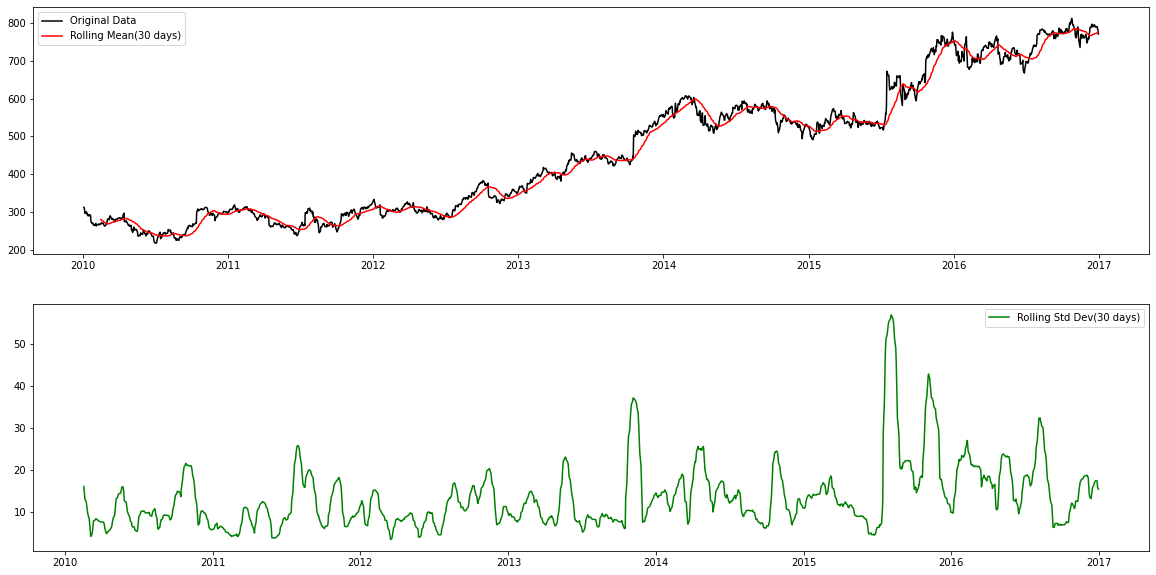

In [24]:
check_stationarity(df_final)

In [26]:
# Applying Log Transformation
df_final_log = np.log(df_final)
df_final_log.head()

date
2010-01-04    5.743661
2010-01-05    5.739248
2010-01-06    5.713716
2010-01-07    5.690161
2010-01-08    5.703404
Name: close, dtype: float64

The above transformation suggests that using logarithmic transformation suits this dataset


Dickey-Fuller test results

Test Statistic      -0.355092
p-value              0.917331
# of lags            0.000000
# of obs          1761.000000
dtype: float64
Critical value at 1%: -3.43407
Critical value at 5%: -2.86318
Critical value at 10%: -2.56764


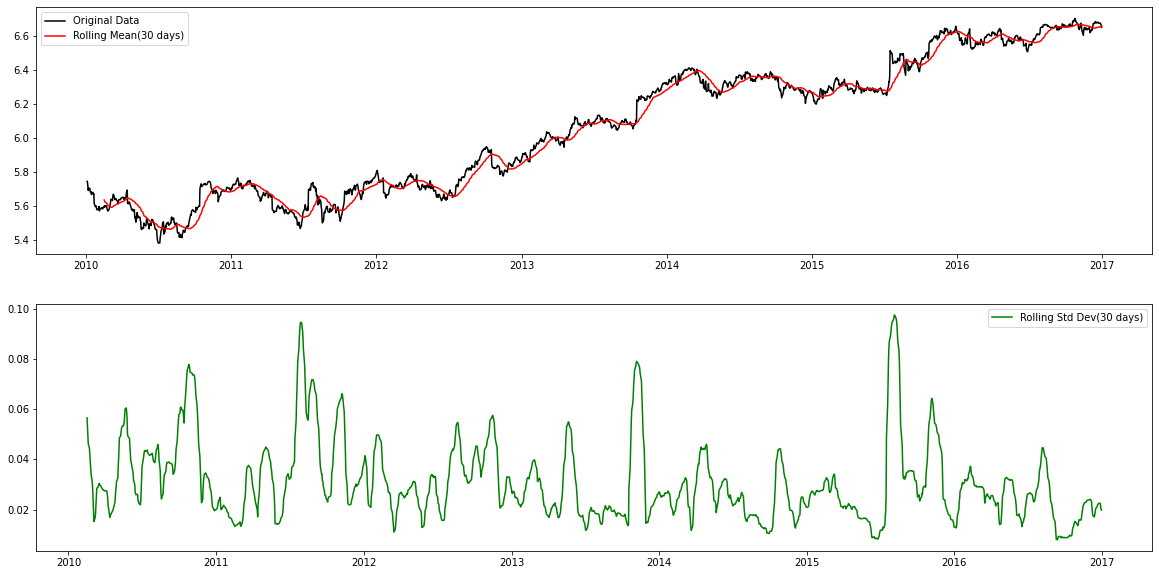

In [28]:
#checking stationarity of the log transform
df_final_log.dropna(inplace=True)
check_stationarity(df_final_log)

Even though the above graph looks very similar, we can see that the scale on the y-axis shows that the values have been scaled down. But it is still not stationary as the rolling mean seems to be deviating to much.

## Log Differencing to achieve stationarity

In [30]:
# log differencing

df_final_log_diff = df_final_log - df_final_log.shift(periods=1)

Dickey-Fuller test results

Test Statistic     -41.056965
p-value              0.000000
# of lags            0.000000
# of obs          1760.000000
dtype: float64
Critical value at 1%: -3.43407
Critical value at 5%: -2.86318
Critical value at 10%: -2.56764


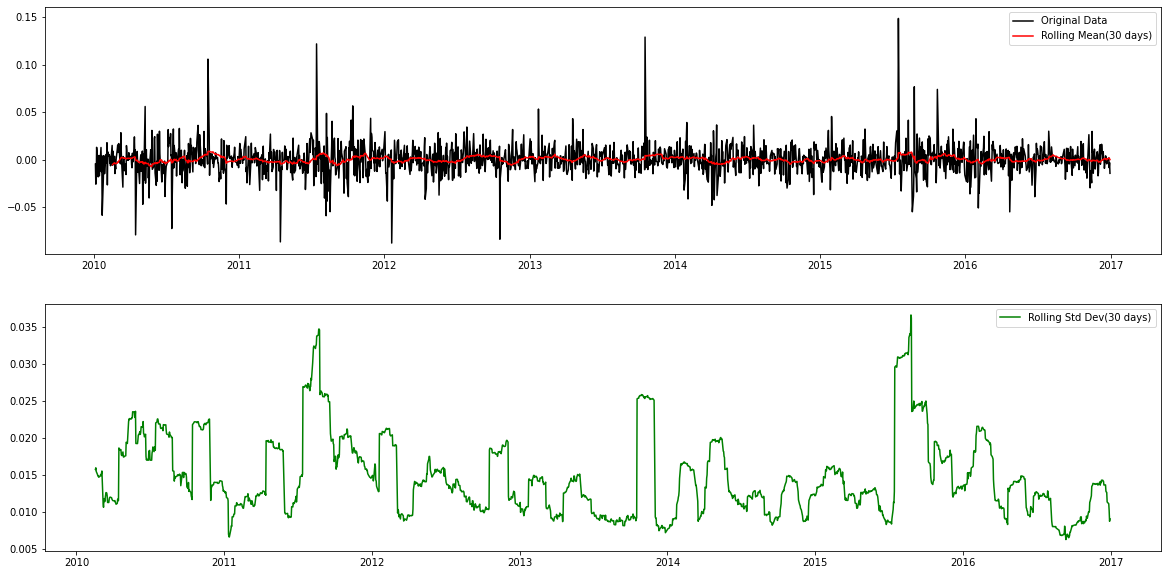

In [32]:
df_final_log_diff.dropna(inplace=True)
check_stationarity(df_final_log_diff)

Test statistic this time is less than the critical values, so we can confirm that now the series is stationary. We can now proceed with time series forecasting of this data and reverse engineer the transformations to reach the correct forecast. We can also check the differencing method with the original dataset which might help us to reduce the re transformations.

In [34]:
# checking simple differencing
df_final_diff = df_final - df_final.shift()

Dickey-Fuller test results

Test Statistic     -25.266396
p-value              0.000000
# of lags            2.000000
# of obs          1758.000000
dtype: float64
Critical value at 1%: -3.43408
Critical value at 5%: -2.86319
Critical value at 10%: -2.56765


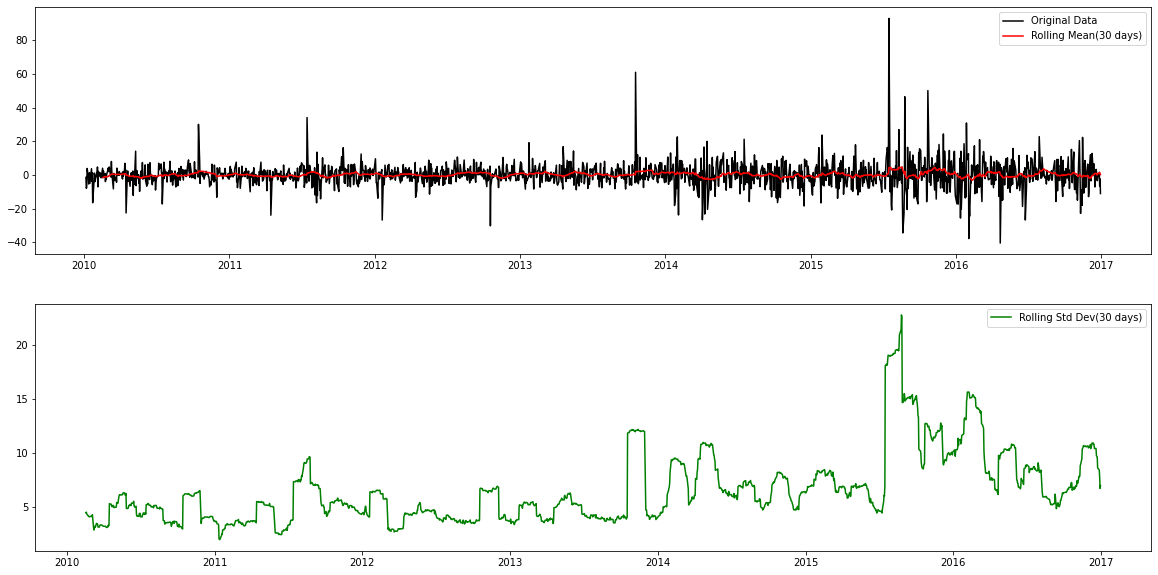

In [36]:
df_final_diff.dropna(inplace=True)
check_stationarity(df_final_diff)

As the test statistic here also is much lower than critical values, we can use this itself

# Applying ARIMA

In [38]:
from statsmodels.tsa.stattools import acf,pacf #auto correlation and partial auto correlation

In [40]:
df_acf = acf(df_final_diff)
df_pacf = pacf(df_final_diff)

In [42]:
import statsmodels.api as sm

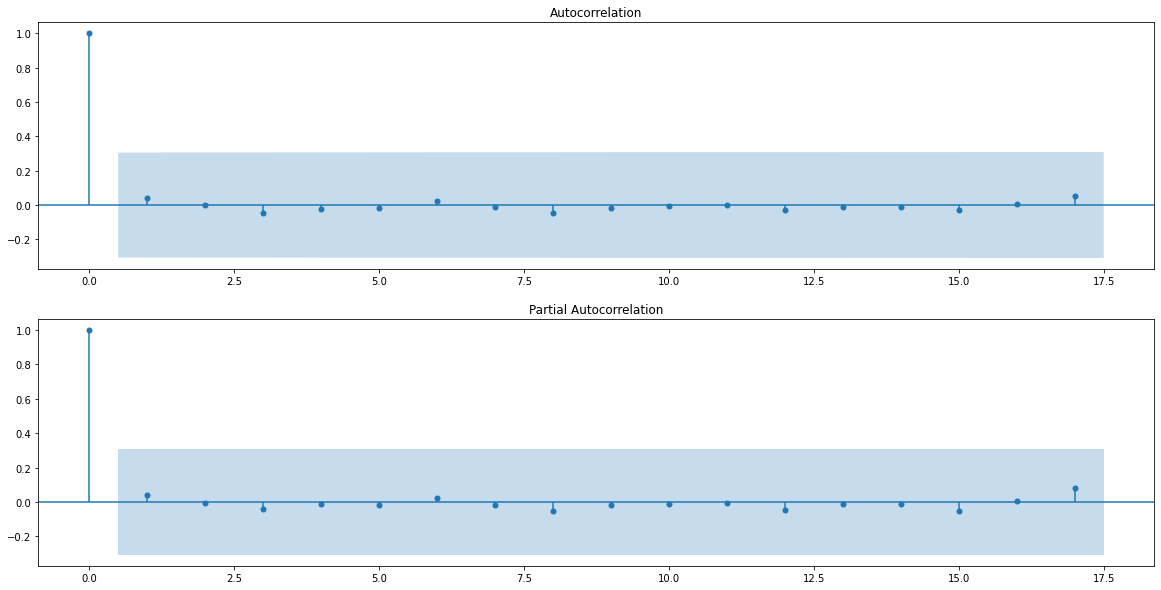

In [44]:
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(211)
fig1 = sm.graphics.tsa.plot_acf(df_acf, ax=ax1)
ax2 = fig1.add_subplot(212)
fig1 = sm.graphics.tsa.plot_pacf(df_pacf, ax=ax2)



Above graph says we have to take parameter p=1 and q=1 for ARIMA.

In [46]:
model = ARIMA(df_final_diff,(1,1,0))


/home/codexharsh/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/codexharsh/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [48]:
fit_model = model.fit(full_output=True)

In [50]:

predictions = model.predict(fit_model.params, start=1760, end=1769)



/home/codexharsh/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [52]:
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                 1760
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6340.298
Method:                       css-mle   S.D. of innovations              8.877
Date:                Wed, 18 Nov 2020   AIC                          12686.596
Time:                        17:09:08   BIC                          12703.015
Sample:                             1   HQIC                         12692.664
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0026      0.143     -0.019      0.985      -0.282       0.277
ar.L1.D.close    -0.4843      0.021    -23.226      0.000      -0.525      -0.443
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0650           +0.0000j            2.0650            0.5000
-----------------------------------------------------------------------------
"""

In [54]:
predictions

array([-2.05722715,  4.21406298, -2.04467144,  0.98625427, -0.48153619,
        0.22927267, -0.11495169,  0.0517463 , -0.02898076,  0.01011304])

In [56]:
fit_model.predict(start=1760, end=1769)


/home/codexharsh/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1759   -2.057227
1760    4.214063
1761   -2.044671
1762    0.986254
1763   -0.481536
1764    0.229273
1765   -0.114952
1766    0.051746
1767   -0.028981
1768    0.010113
dtype: float64

In [58]:
# Re transforming the series to original
pred_model_diff = pd.Series(fit_model.fittedvalues,copy=True)
pred_model_diff.head()

date
2010-01-06   -0.002642
2010-01-07    3.124857
2010-01-08   -0.382658
2010-01-11   -5.330324
2010-01-12    2.126164
dtype: float64

In [60]:
pred_model_diff_cumsum = pred_model_diff.cumsum()
pred_model_diff_cumsum.head()

date
2010-01-06   -0.002642
2010-01-07    3.122215
2010-01-08    2.739557
2010-01-11   -2.590768
2010-01-12   -0.464604
dtype: float64

In [62]:
# Element-wise addition back to original time series
df_final_trans = df_final.add(pred_model_diff_cumsum, fill_value=0)
# Last 5 rows of fitted values
df_final_trans.tail()

date
2016-12-23    783.957368
2016-12-27    784.649156
2016-12-28    776.697238
2016-12-29    778.375283
2016-12-30    765.348085
dtype: float64

In [64]:
df_final.tail()

date
2016-12-23    789.909973
2016-12-27    791.549988
2016-12-28    785.049988
2016-12-29    782.789978
2016-12-30    771.820007
Name: close, dtype: float64

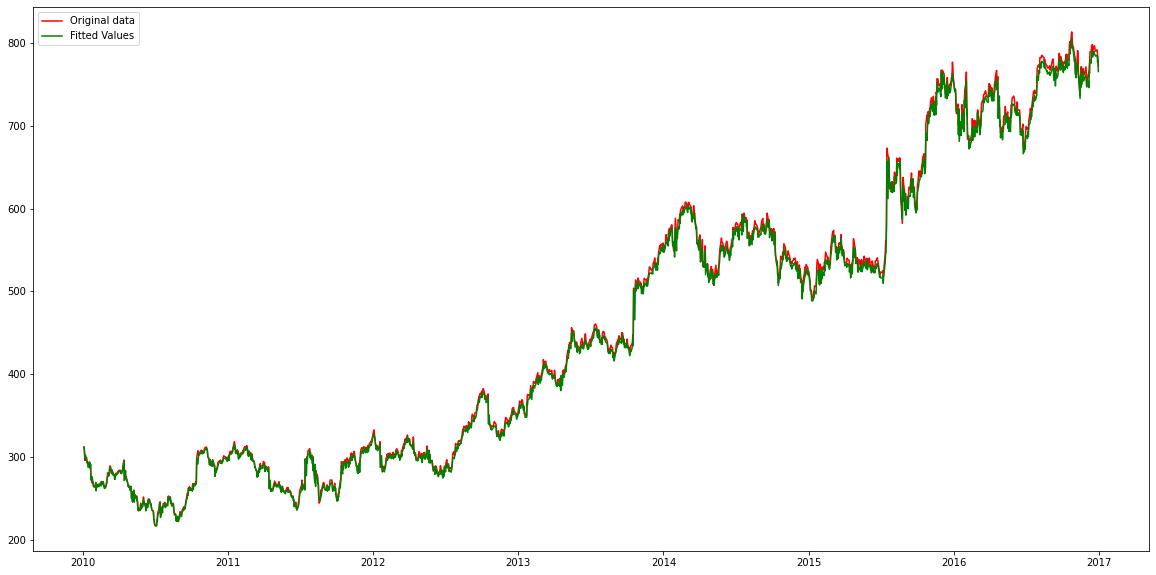

In [66]:
# Plot of orignal data and fitted values
plt.figure(figsize=(20,10))
plt.plot(df_final, color='red', label='Original data')
plt.plot(df_final_trans, color='green', label='Fitted Values')
plt.legend()
plt.savefig("Plots/google_full_preds.png")


We can see that the model is fitting the data very well. But we need to analyse it in a close manner to get the actual picture. So we plot the last 30 values only below

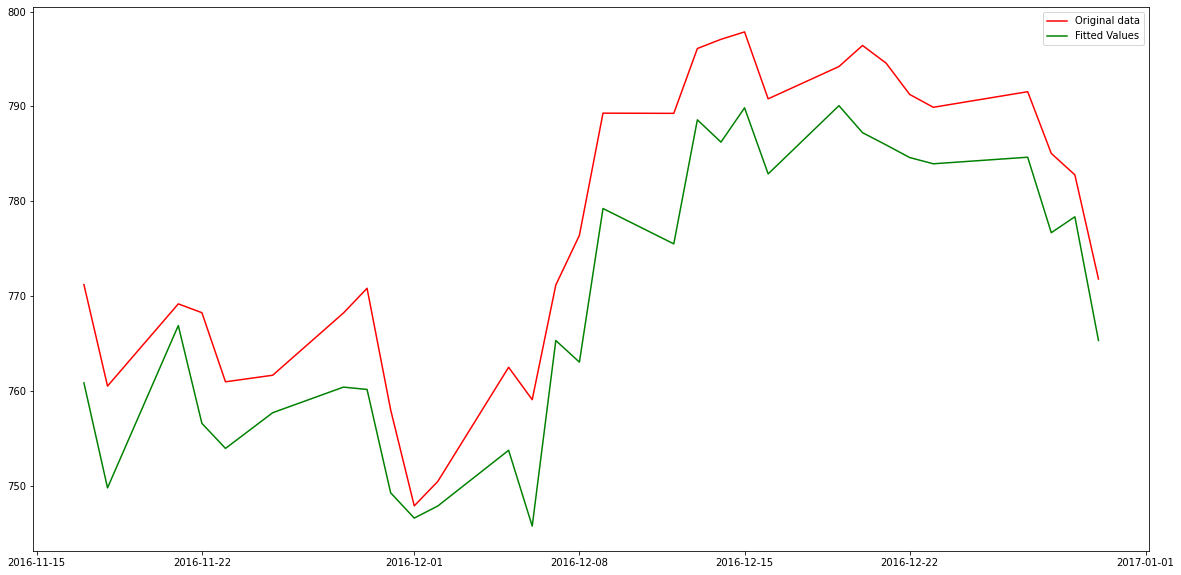

In [68]:
plt.figure(figsize=(20,10))
plt.plot(df_final[-30:], color='red', label='Original data')
plt.plot(df_final_trans[-30:], color='green', label='Fitted Values')
plt.legend()
plt.savefig("Plots/google_end_30_preds.png")

In [70]:
x=df_final.values
y=df_final_trans.values

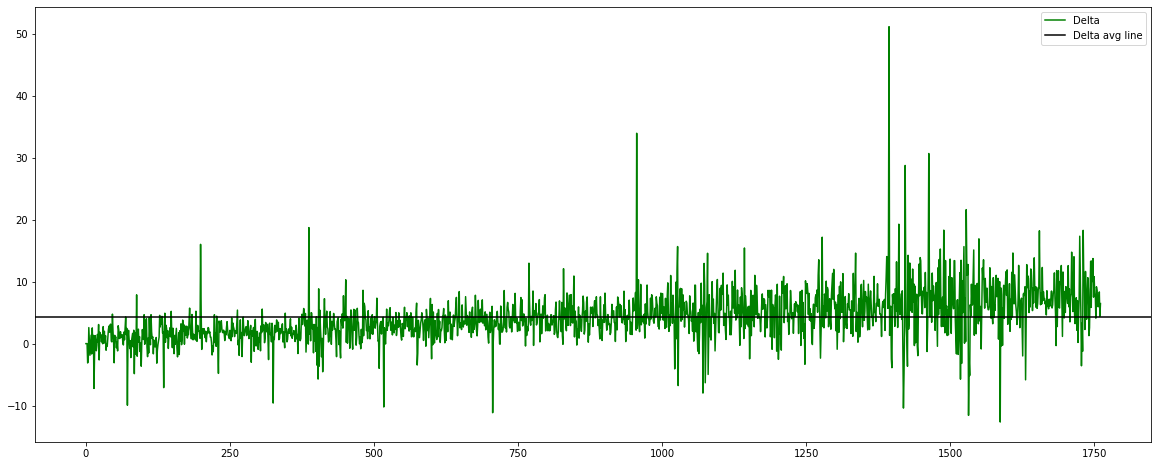

In [72]:
# Trend of Error
plt.figure(figsize=(20,8))
plt.plot((x - y), color='green', label='Delta')
plt.axhline((x-y).mean(), color='black', label='Delta avg line')
plt.legend()

We can see that the average error appears to be around 4.5$ per share daily

## Forecasting for future values

In [74]:
final_pred = []
for i in predictions:
    t = df_final[-1] + i
    final_pred.append(t)

In [76]:
final_pred = pd.Series(final_pred)
final_pred

0    769.762780
1    776.034070
2    769.775336
3    772.806261
4    771.338471
5    772.049280
6    771.705055
7    771.871753
8    771.791026
9    771.830120
dtype: float64

In [78]:
df_final

date
2010-01-04    312.205308
2010-01-05    310.830459
2010-01-06    302.994813
2010-01-07    295.941242
2010-01-08    299.886470
                 ...    
2016-12-23    789.909973
2016-12-27    791.549988
2016-12-28    785.049988
2016-12-29    782.789978
2016-12-30    771.820007
Name: close, Length: 1762, dtype: float64

## Testing Our Model with Recent Data

In [80]:
# using https://www.wsj.com/market-data/quotes/GOOG/historical-prices
# importing data

df_new = pd.read_csv("Dataset/goog_current_data.csv",index_col=0)

df_new.head()


,Open,High,Low,Close,Volume
Date,,,,,
11-17-2020,1776.94,1785.00,1767.000,1770.15,1147114
11-16-2020,1771.70,1799.07,1767.690,1781.38,1246785
11-13-2020,1757.63,1781.04,1744.550,1777.02,1500574
11-12-2020,1747.63,1768.27,1745.600,1749.84,1248754
11-11-2020,1750.00,1764.22,1747.365,1752.71,1263966


In [82]:
df_new.index.sort_values()

Index(['05-20-2020', '05-21-2020', '05-22-2020', '05-26-2020', '05-27-2020',
       '05-28-2020', '05-29-2020', '06-01-2020', '06-02-2020', '06-03-2020',
       ...
       '11-04-2020', '11-05-2020', '11-06-2020', '11-09-2020', '11-10-2020',
       '11-11-2020', '11-12-2020', '11-13-2020', '11-16-2020', '11-17-2020'],
      dtype='object', name='Date', length=127)

In [85]:
# Converting to pd datetime format
df_new.index = pd.to_datetime(df_new.index,format="%m-%d-%Y")
df_new.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-17,1776.94,1785.00,1767.000,1770.15,1147114
2020-11-16,1771.70,1799.07,1767.690,1781.38,1246785
2020-11-13,1757.63,1781.04,1744.550,1777.02,1500574
2020-11-12,1747.63,1768.27,1745.600,1749.84,1248754
2020-11-11,1750.00,1764.22,1747.365,1752.71,1263966


In [90]:
print(df.index.dtype)

object datetime64[ns]


In [94]:
df_new_final = df_new.drop([' Open',' High',' Low',' Volume'],axis=1)

df_new_final = pd.Series(df_new_final[' Close'])

In [95]:
type(df_new_final)

pandas.core.series.Series

Dickey-Fuller test results

Test Statistic     -2.433169
p-value             0.132593
# of lags           0.000000
# of obs          126.000000
dtype: float64
Critical value at 1%: -3.48335
Critical value at 5%: -2.88477
Critical value at 10%: -2.57916


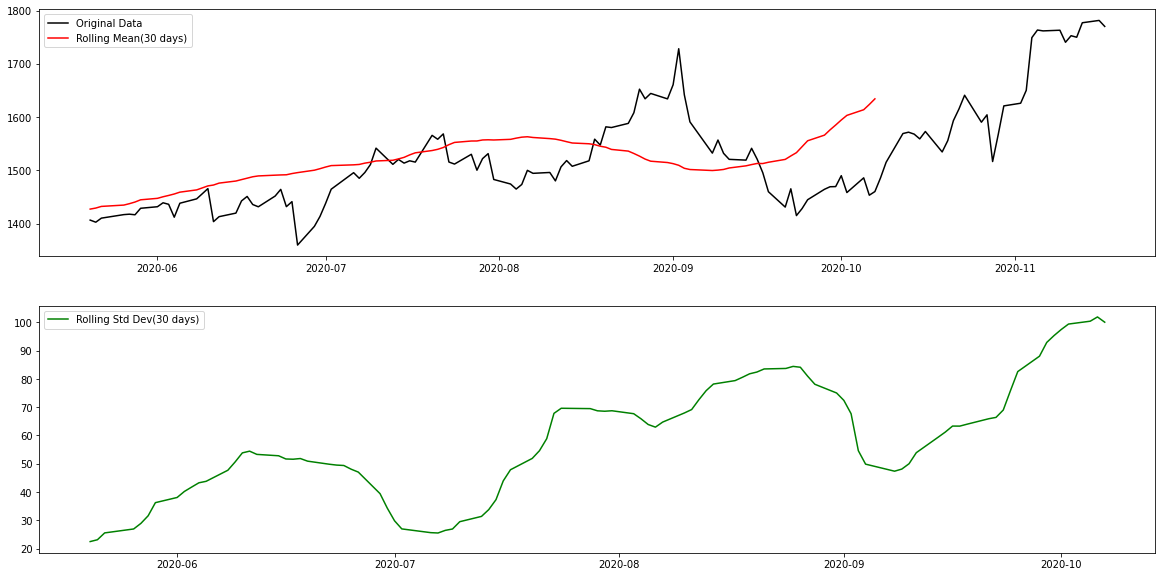

In [96]:
check_stationarity(df_new_final)

## Taking Log 

In [98]:
df_new_final_log = np.log(df_new_final)
df_new_final_log.head()

Date
2020-11-17    7.478820
2020-11-16    7.485144
2020-11-13    7.482693
2020-11-12    7.467280
2020-11-11    7.468918
Name:  Close, dtype: float64

## Using normal Differencing

In [99]:
df_new_final_diff = df_new_final - df_new_final.shift(periods=1)

Dickey-Fuller test results

Test Statistic   -1.189893e+01
p-value           5.634977e-22
# of lags         0.000000e+00
# of obs          1.250000e+02
dtype: float64
Critical value at 1%: -3.48378
Critical value at 5%: -2.88495
Critical value at 10%: -2.57926


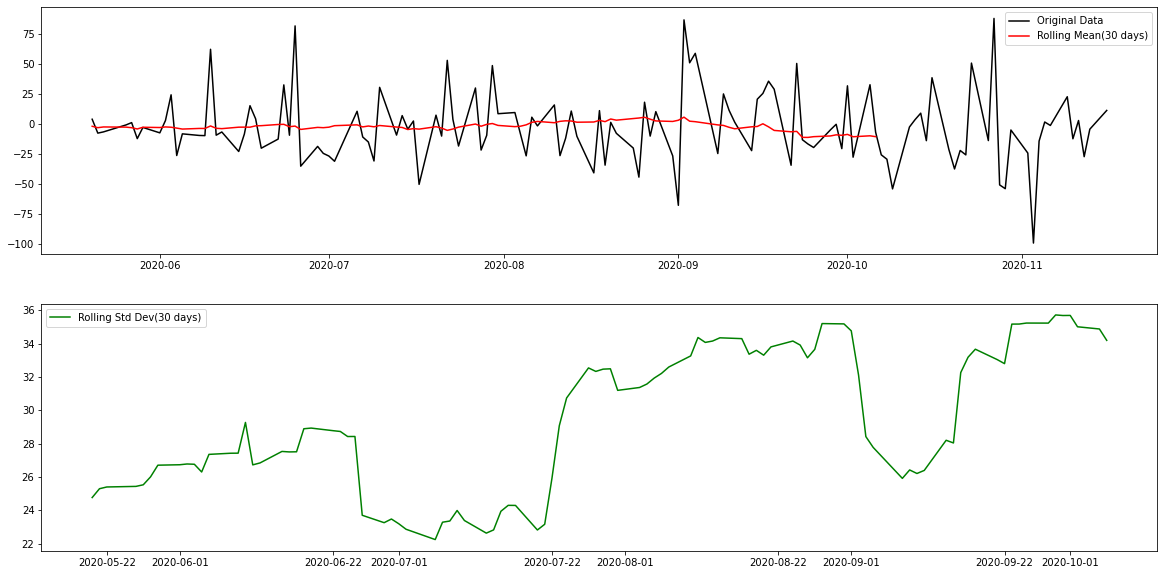

In [100]:
df_new_final_diff.dropna(inplace=True)
check_stationarity(df_new_final_diff)

- Test statistic is coming much greater than critical value, so we can go ahead with applying ARIMA on the data

In [101]:
df_new_acf = acf(df_new_final_diff)
df_new_pacf = pacf(df_new_final_diff)

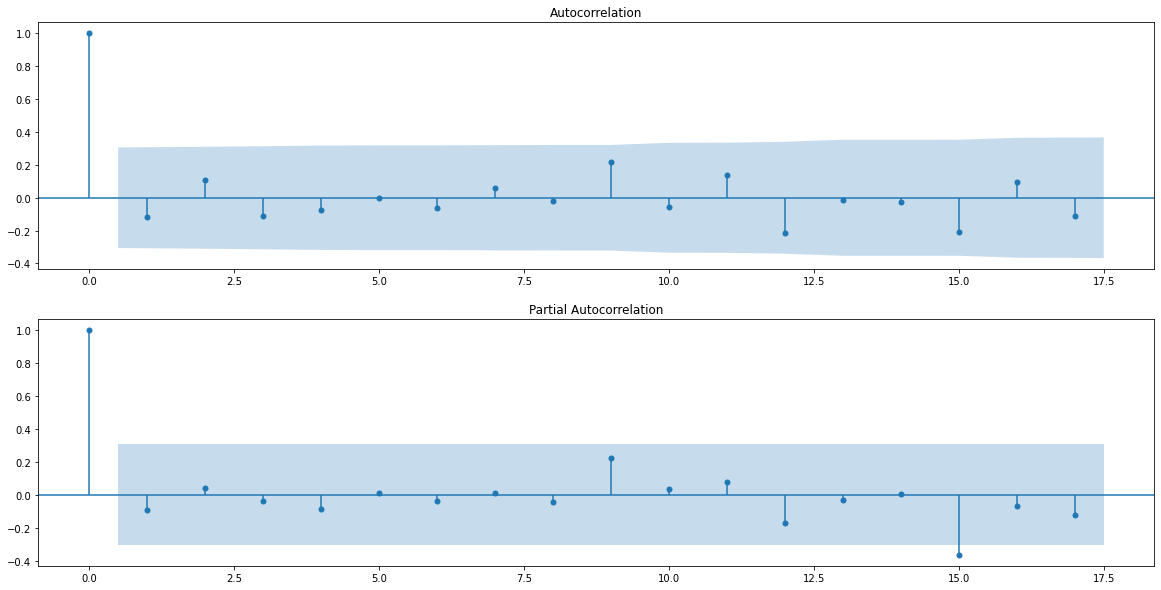

In [102]:
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(211)
fig1 = sm.graphics.tsa.plot_acf(df_new_acf, ax=ax1)
ax2 = fig1.add_subplot(212)
fig1 = sm.graphics.tsa.plot_pacf(df_new_pacf, ax=ax2)



In [120]:
model_new = ARIMA(df_new_final_diff,(1,1,0))

/home/codexharsh/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/codexharsh/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/home/codexharsh/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/codexharsh/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. fore

In [121]:
fit_model_new = model_new.fit(full_output=True)

In [122]:
df_new_final_diff.size

126

In [123]:
predictions_new = model_new.predict(fit_model_new.params,start = 116,end=126)

/home/codexharsh/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [124]:
fit_model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D. Close   No. Observations:                  125
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -623.370
Method:                       css-mle   S.D. of innovations             35.394
Date:                Wed, 18 Nov 2020   AIC                           1252.740
Time:                        18:56:02   BIC                           1261.225
Sample:                             1   HQIC                          1256.187
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0472      2.039     -0.023      0.982      -4.044       3.950
ar.L1.D. Close    -0.5568      0.074     -7.570      0.000      -0.701      -0.413
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7958           +0.0000j            1.7958            0.5000
-----------------------------------------------------------------------------
"""

In [125]:
predictions_new

array([  9.94426346, -28.14422069,  11.8208452 ,   5.62868228,
        -2.57927468,   5.09967556,  -7.47954749,   1.00126557,
         3.14513493,   0.49453281,  -6.49949293])

In [126]:
# Re Transforming to original
pred_new_model_diff = pd.Series(fit_model_new.fittedvalues,copy=True)


In [127]:
pred_new_model_diff_cumsum = pred_new_model_diff.cumsum()
pred_new_model_diff_cumsum.head()



Date
2020-11-13    -0.047181
2020-11-12     8.560645
2020-11-11    21.194490
2020-11-10     4.387718
2020-11-09    12.772804
dtype: float64

In [128]:
df_final_new_trans = df_new_final.add(pred_new_model_diff_cumsum,fill_value=0)
df_final_new_trans.tail()

Date
2020-11-11    1773.904490
2020-11-12    1758.400645
2020-11-13    1776.972819
2020-11-16    1781.380000
2020-11-17    1770.150000
dtype: float64

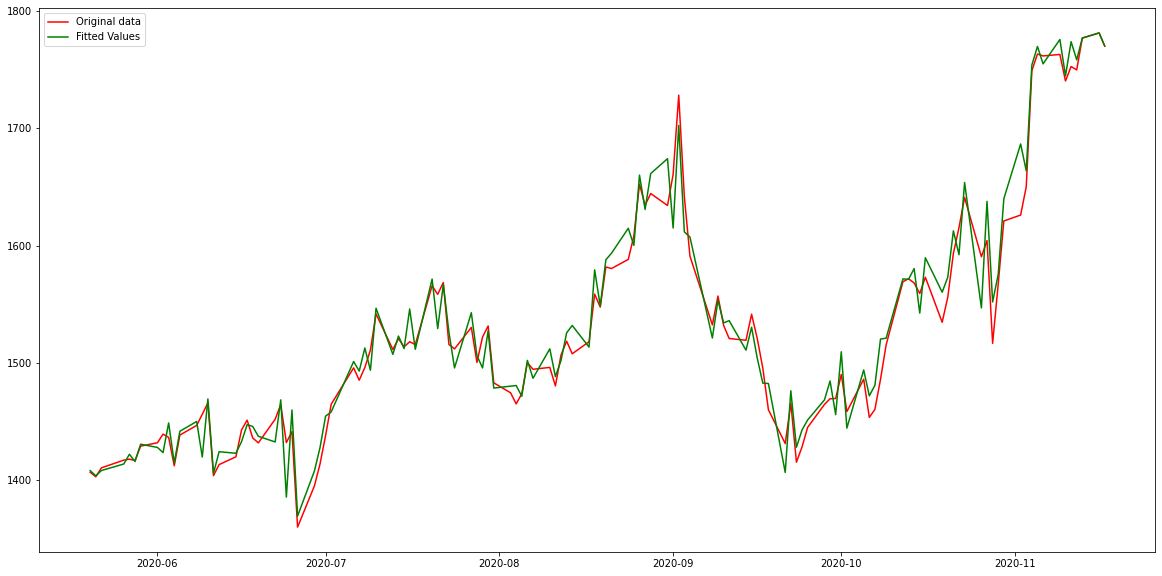

In [129]:
# Plot of orignal data and fitted values
plt.figure(figsize=(20,10))
plt.plot(df_new_final, color='red', label='Original data')
plt.plot(df_final_new_trans, color='green', label='Fitted Values')
plt.legend()
plt.savefig("Plots/google_current_full_preds.png")

In [150]:
# Now let us see how the stock would behave for the next 5 days - (18)
final_new_pred = []
bt = np.flip(predictions_new)
for i in bt:
    t = df_new_final[0] + i
    final_new_pred.append(t)

In [151]:
df_new_final

Date
2020-11-17    1770.15
2020-11-16    1781.38
2020-11-13    1777.02
2020-11-12    1749.84
2020-11-11    1752.71
               ...   
2020-05-27    1417.84
2020-05-26    1417.02
2020-05-22    1410.42
2020-05-21    1402.80
2020-05-20    1406.72
Name:  Close, Length: 127, dtype: float64

In [152]:
final_new_pred = pd.Series(final_new_pred)
final_new_pred

0     1763.650507
1     1770.644533
2     1773.295135
3     1771.151266
4     1762.670453
5     1775.249676
6     1767.570725
7     1775.778682
8     1781.970845
9     1742.005779
10    1780.094263
dtype: float64